In [1]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from mask_utils.engine import train_one_epoch, evaluate
import os
import numpy as np
import torch
from PIL import Image
import mask_utils.transforms as T
import mask_utils.utils as utils
import cv2

In [3]:

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "labels"))))
        print (self.imgs[-5:])

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "labels", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert("LA")
        mask = cv2.imread(mask_path,0)
        # convert the PIL Image into a numpy array
        mask = np.array(mask) 
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:] 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]  
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
       
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
       

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, box_detections_per_img = 350)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('dataset/cells', get_transform(train=True))
    dataset_test = PennFudanDataset('dataset/cells', get_transform(train=False))

    # split the dataset in train and test set
#     indices = torch.randperm(len(dataset)).tolist()
    indices = torch.arange(len(dataset)).tolist()
    print (len(indices))
    dataset = torch.utils.data.Subset(dataset, indices[:2]+indices[7:])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[2:7])
    print (len(dataset),len(dataset_test))
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes) 
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.05)

    # let's train it for 10 epochs
    num_epochs = 10
#     model.load_state_dict(torch.load("checkpoints/8_epoch.pt"))
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        if (epoch+2) % 5 == 0:
            evaluate(model, data_loader_test, device=device)
            path = "checkpoints/"+str(epoch)+"_epoch.pt"
            torch.save(model.state_dict(), path)
    return model, data_loader_test,data_loader
    print("That's it!")

In [13]:
model, test_loader,train_loader = main()

['51.png', '6.png', '7.png', '8.png', '9.png']
['51.png', '6.png', '7.png', '8.png', '9.png']
50
45 5
Epoch: [0]  [ 0/23]  eta: 0:01:42  lr: 0.000232  loss: 7.4264 (7.4264)  loss_classifier: 0.5887 (0.5887)  loss_box_reg: 0.5029 (0.5029)  loss_mask: 2.0928 (2.0928)  loss_objectness: 3.9932 (3.9932)  loss_rpn_box_reg: 0.2487 (0.2487)  time: 4.4573  data: 3.8054  max mem: 4080
Epoch: [0]  [ 5/23]  eta: 0:00:19  lr: 0.001367  loss: 3.2471 (4.7476)  loss_classifier: 0.5775 (0.5768)  loss_box_reg: 0.5064 (0.5186)  loss_mask: 1.4535 (1.6913)  loss_objectness: 0.3267 (1.6723)  loss_rpn_box_reg: 0.2613 (0.2886)  time: 1.1110  data: 0.6549  max mem: 4418
Epoch: [0]  [10/23]  eta: 0:00:14  lr: 0.002502  loss: 2.5257 (3.5643)  loss_classifier: 0.5371 (0.5471)  loss_box_reg: 0.5029 (0.5094)  loss_mask: 0.9566 (1.2064)  loss_objectness: 0.2805 (1.0151)  loss_rpn_box_reg: 0.2927 (0.2863)  time: 1.0800  data: 0.5980  max mem: 4418
Epoch: [0]  [15/23]  eta: 0:00:06  lr: 0.003638  loss: 2.0273 (3.0252)

Epoch: [4]  [10/23]  eta: 0:00:13  lr: 0.005000  loss: 0.9025 (0.9218)  loss_classifier: 0.2110 (0.2241)  loss_box_reg: 0.1831 (0.1867)  loss_mask: 0.2607 (0.2653)  loss_objectness: 0.0412 (0.0428)  loss_rpn_box_reg: 0.2028 (0.2029)  time: 1.0070  data: 0.6188  max mem: 4444
Epoch: [4]  [15/23]  eta: 0:00:07  lr: 0.005000  loss: 0.8585 (0.8903)  loss_classifier: 0.1956 (0.2096)  loss_box_reg: 0.1800 (0.1733)  loss_mask: 0.2496 (0.2586)  loss_objectness: 0.0402 (0.0430)  loss_rpn_box_reg: 0.1952 (0.2058)  time: 0.9674  data: 0.5808  max mem: 4444
Epoch: [4]  [20/23]  eta: 0:00:02  lr: 0.005000  loss: 0.8580 (0.8767)  loss_classifier: 0.1956 (0.2061)  loss_box_reg: 0.1658 (0.1714)  loss_mask: 0.2496 (0.2576)  loss_objectness: 0.0393 (0.0409)  loss_rpn_box_reg: 0.1930 (0.2006)  time: 0.8605  data: 0.4751  max mem: 4444
Epoch: [4]  [22/23]  eta: 0:00:00  lr: 0.005000  loss: 0.8580 (0.8925)  loss_classifier: 0.1947 (0.2098)  loss_box_reg: 0.1658 (0.1747)  loss_mask: 0.2548 (0.2599)  loss_ob

KeyboardInterrupt: 

In [6]:
def visualize(image,scores, threshold = 0.001):
    final_mask = np.zeros((image.shape[1],image.shape[2],3))
    for channel in image:
        channel[channel > threshold] = 1
        channel[channel<=threshold]=0
        final_mask[channel==1] = np.random.randint(1,255,size = 3).tolist()
        final_mask[final_mask>255]=255
    final_mask= final_mask.astype("uint8")
    plt.figure(figsize=(20,10))
    plt.imshow(final_mask)
    plt.show()
    print ("Final Shape:",final_mask.shape)
    return final_mask
        
        

(73, 1022, 1024)


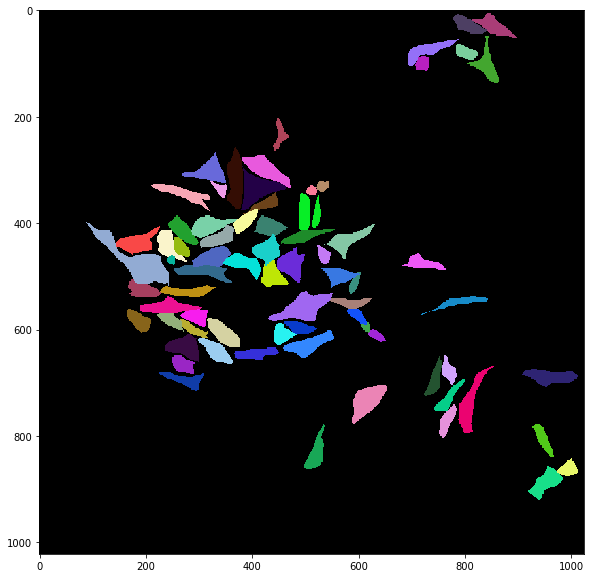

Final Shape: (1022, 1024, 3)
max output instances  tensor(104, device='cuda:0')


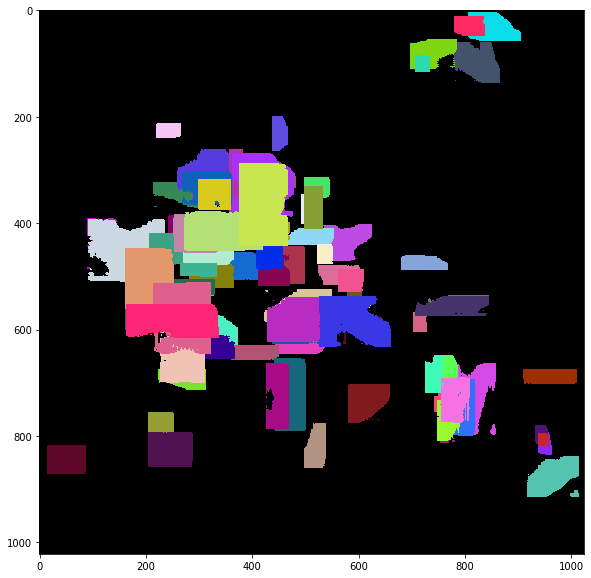

Final Shape: (1022, 1024, 3)


NameError: name 'img' is not defined

In [7]:
import matplotlib.pyplot as plt

model.eval()
i = 0
for image,_ in test_loader:
    image = list(img.to("cuda") for img in image)
     
    print(_[0]["masks"].cpu().detach().numpy().shape)
    target = _[0]["masks"].cpu().detach().numpy()
    lab = visualize(_[0]["masks"].cpu().detach().numpy(),[1]*target.shape[0])
    target = np.sum(_[0]["masks"].cpu().detach().numpy(),0)
#     print (target.shape)
    outputs = model(image)
    scores =outputs[0]["scores"]
#     print (outputs[0]["masks"].shape)
    mask = outputs[0]["masks"].squeeze()
    print ("max output instances ",torch.sum(scores>0.001))
    mask = mask.cpu().detach().numpy()
    pred = visualize(mask,scores)
    print (pred.shape,lab.shape,img.shape)
    print ("mask",mask.shape,"\n\n\n\n\n")
#     print(len(image))
    img = image[0].cpu().detach().numpy()
    img = np.transpose(img,[1,2,0])
    cv2.imwrite(str(i)+"_raw.jpg",(img*255).astype("uint8"))
    cv2.imwrite(str(i)+"_label.jpg",lab)
    cv2.imwrite(str(i)+"_prediction.jpg",pred)
    i+=1
#     print (img.shape,"shape")
#     plt.figure(figsize=(20,10))
#     plt.imshow(mask)
#     plt.show()
   
    
     

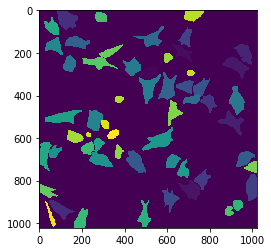

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
im = cv2.imread("outputs/2_instances.png",-1)
im = im.astype("uint8")
plt.imshow(im)
plt.show()